L

In this section, we start designing FIR filters using the windowing design method. This is the most straightforward design method.


In [45]:
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import firwin, freqz


In [50]:
# Filter requirements
fs = 1000 # Sample rate, Hz
cutoff = np.np.np.pi / 2 # Desired cutoff frequency, Hz
trans_width = 0.1 * np.pi # Width of transition from pass band to stop band, Hz
numtaps = 15 # Size of the FIR filter

## Low Pass Filter using Blackman window method

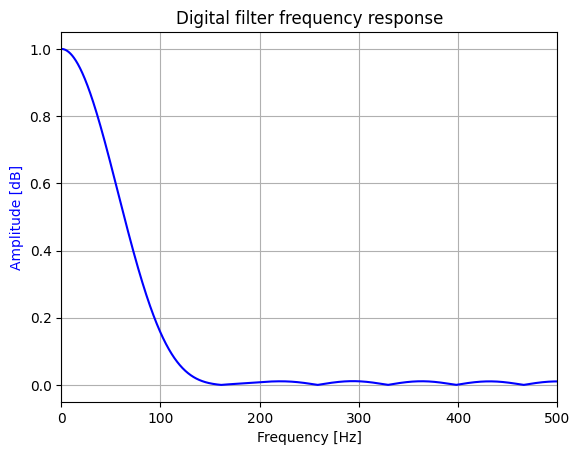

In [52]:
# Compute the filter coefficients using the firwin function
taps = firwin(numtaps, cutoff, window='hamming', pass_zero=True, fs=fs)

# Compute the frequency response of the filter
w, h = freqz(taps, 1, worN=2000)

# Plot the frequency response
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')
ax1.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlim([0, 0.5*fs])
ax1.grid()

plt.show()